In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from sklearn.model_selection import StratifiedKFold

split_num = 10


# data input 
path = 'trainrat_new.txt'
data = pd.read_csv(path,sep=' ')
print(len(data))

# Data extraction,Win
win_data = data[data.label == "W"]
win_data = win_data.assign(W=1,D=0,L=0) 
win_data = win_data.drop("label",axis=1)
win_data = win_data.sample(n=len(win_data))# random sort

# Data extraction,Draw
draw_data = data[data.label == "D"]
draw_data = draw_data.assign(W=0,D=1,L=0)
draw_data = draw_data.drop("label",axis=1)
draw_data = draw_data.sample(n=len(draw_data))# random sort

# Data extraction,Lose
lose_data = data[data.label == "L"]
lose_data = lose_data.assign(W=0,D=0,L=1) 
lose_data = lose_data.drop("label",axis=1)
lose_data = lose_data.sample(n=len(lose_data))# random sort

# Group data together,use for normal k-fold
all_data = pd.concat([win_data, draw_data, lose_data])
all_data = all_data.sample(n=len(all_data))# random sort
#yAll = xAll[["W","D","L"]]

# Data drop
#xWin = xWin.drop(["W","D","L"],axis=1)
#xDraw = xDraw.drop(["W","D","L"],axis=1)
#xLose = xLose.drop(["W","D","L"],axis=1)
#xAll = xAll.drop(["W","D","L"],axis=1)

# Data separate and making dataset
win_data_separate = []
draw_data_separate = []
lose_data_separate = []
all_data_separate = []
wdl_separate = []
for i in range(split_num):
    win_data_separate.append(win_data[i::split_num])
    draw_data_separate.append(draw_data[i::split_num])
    lose_data_separate.append(lose_data[i::split_num])
    all_data_separate.append(all_data[i::split_num])
    # merge for stratified sampling
    wdl_separate.append(pd.concat([win_data_separate[i],draw_data_separate[i],lose_data_separate[i]]))
    # assign a number to make final input data
    wdl_separate[i] = wdl_separate[i].assign(separate_num=i)
    all_data_separate[i] = all_data_separate[i].assign(separate_num=i)

# integrate everything once
wdl_separate_merge = wdl_separate[0]
all_data_separate_merge = all_data_separate[0]
for i in range(1,split_num):
    wdl_separate_merge = wdl_separate_merge.append(wdl_separate[i])
    all_data_separate_merge = all_data_separate_merge.append(all_data_separate[i])

#print(len(wdl_separate_merge))
#print(len(all_data_separate_merge))
    
    
# make final input data
x_train = []
y_train = []
x_val = []
y_val = []
xAll_train = []
yAll_train = []
xAll_val = []
yAll_val = []
for i in range(split_num):
    x_train.append(wdl_separate_merge[wdl_separate_merge['separate_num'] != i])
    x_val.append(wdl_separate_merge[wdl_separate_merge['separate_num'] == i])
    xAll_train.append(all_data_separate_merge[all_data_separate_merge['separate_num'] != i])
    xAll_val.append(all_data_separate_merge[all_data_separate_merge['separate_num'] == i])
for i in range(split_num):
    # delete separate_num
    x_train[i] = x_train[i].drop(['separate_num'],axis=1)
    x_val[i] = x_val[i].drop(['separate_num'],axis=1)
    xAll_train[i] = xAll_train[i].drop(['separate_num'],axis=1)
    xAll_val[i] = xAll_val[i].drop(['separate_num'],axis=1)
    # random sort
    x_train[i] = x_train[i].sample(n=len(x_train[i]))
    x_val[i] = x_val[i].sample(n=len(x_val[i]))
    xAll_train[i] = xAll_train[i].sample(n=len(xAll_train[i]))
    xAll_val[i] = xAll_val[i].sample(n=len(xAll_val[i]))
    
    # separate x and y
    y_train.append(x_train[i][["W","D","L"]])
    y_val.append(x_val[i][["W","D","L"]])
    yAll_train.append(xAll_train[i][["W","D","L"]])
    yAll_val.append(xAll_val[i][["W","D","L"]])
    x_train[i] = x_train[i].drop(["W","D","L"],axis=1)
    x_val[i] = x_val[i].drop(["W","D","L"],axis=1)
    xAll_train[i] = xAll_train[i].drop(["W","D","L"],axis=1)
    xAll_val[i] = xAll_val[i].drop(["W","D","L"],axis=1)
    
    #translate pandas to numpy
    x_train[i] = x_train[i].values.astype('float32') 
    x_val[i] = x_val[i].values.astype('float32') 
    y_train[i] = y_train[i].values
    y_val[i] = y_val[i].values


28186


In [2]:
def RPS(y_true, y_pred):
    output = 0.
    data_num = len(y_true)
    for i in range(data_num):
        times = len(y_true[i]) - 1 
        cumulative_sum = 0.
        score = 0.
        for time in range(times):
            cumulative_sum += y_true[i,time] - y_pred[i,time]
            score += cumulative_sum ** 2
        score /= times
        output += score
    
    output /= data_num
    return output


In [3]:
import chainer
import chainer.links as L
import chainer.functions as F
from chainer import Sequential

# craete model
# net としてインスタンス化
n_input = 8
n_hidden = 10
n_output = 3

# create 10 model for 10-fold-crossvalidation?
optimizer = []
net = []

for i in range(10):
    net.append(Sequential(
        L.Linear(n_input, n_hidden), F.relu,
        L.Linear(n_hidden, n_hidden), F.relu,
        L.Linear(n_hidden, n_output), F.softmax)
    )
    optimizer.append(chainer.optimizers.SGD(lr=0.01))
    optimizer[i].setup(net[i])
    



/home/tubotu/.local/lib/python3.6/site-packages/chainer/backends/cuda.py:143: UserWarning: cuDNN is not enabled.
Please reinstall CuPy after you install cudnn
(see https://docs-cupy.chainer.org/en/stable/install.html#install-cudnn).
  'cuDNN is not enabled.\n'


In [4]:
#print(np.random.permutation(range(len(x_train))))
n_epoch = 30
batchsize = 16
# ログの保存用
results_train_data = []
results_valid_data = []


for data_num in range(len(x_train)):
    # ログの保存用
    results_train = {
        'loss': [],
        'accuracy': []
    }
    results_valid = {
        'loss': [],
        'accuracy': []
    }
    iteration = 0
    for epoch in range(n_epoch):
        # 各バッチ毎の目的関数の出力と分類精度の保存用
        loss_list = []
        #accuracy_list = []

        for i in range(0, len(x_train[data_num]), batchsize):
            # バッチを準備
            x_train_batch = x_train[data_num][i:i+batchsize,:]
            y_train_batch = y_train[data_num][i:i+batchsize,:]

            # 予測値を出力
            y_train_batch_pred = net[data_num](x_train_batch)
            # 目的関数を適用し、分類精度を計算
            loss_train_batch = RPS(y_train_batch, y_train_batch_pred)
            #print(loss_train_batch)
            #accuracy_train_batch = F.accuracy(y_train_batch_pred, y_train_batch)

            loss_list.append(loss_train_batch.array)
            #accuracy_list.append(accuracy_train_batch.array)

            # 勾配のリセットと勾配の計算
            net[data_num].cleargrads()
            loss_train_batch.backward()

            # パラメータの更新
            optimizer[data_num].update()

            # カウントアップ
            iteration += 1
        # 訓練データに対する目的関数の出力と分類精度を集計
        loss_train = np.mean(loss_list)
        #accuracy_train = np.mean(accuracy_list)

        # 1エポック終えたら、検証データで評価
        # 検証データで予測値を出力
        with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
            y_val_pred = net[data_num](x_val[data_num])

        #print(y_val)
        # 目的関数を適用し、分類精度を計算
        loss_val = RPS(y_val_pred, y_val[data_num])
        #accuracy_val = F.accuracy(y_val_pred, y_val[data_num])

        # 結果の表示
        print('epoch: {}, iteration: {}, loss (train): {:.4f}, loss (valid): {:.4f}'.format(
            epoch, iteration, loss_train, loss_val.array))

        # ログを保存
        results_train['loss'] .append(loss_train)
        #results_train['accuracy'] .append(accuracy_train)
        results_valid['loss'].append(loss_val.array)
        #results_valid['accuracy'].append(accuracy_val.array)
        
    results_train_data.append(results_train)
    results_valid_data.append(results_valid)


epoch: 0, iteration: 1586, loss (train): 0.2191, loss (valid): 0.2122
epoch: 1, iteration: 3172, loss (train): 0.2130, loss (valid): 0.2089
epoch: 2, iteration: 4758, loss (train): 0.2116, loss (valid): 0.2081
epoch: 3, iteration: 6344, loss (train): 0.2111, loss (valid): 0.2078
epoch: 4, iteration: 7930, loss (train): 0.2108, loss (valid): 0.2075
epoch: 5, iteration: 9516, loss (train): 0.2106, loss (valid): 0.2073
epoch: 6, iteration: 11102, loss (train): 0.2104, loss (valid): 0.2072
epoch: 7, iteration: 12688, loss (train): 0.2103, loss (valid): 0.2072
epoch: 8, iteration: 14274, loss (train): 0.2102, loss (valid): 0.2071
epoch: 9, iteration: 15860, loss (train): 0.2101, loss (valid): 0.2070
epoch: 10, iteration: 17446, loss (train): 0.2100, loss (valid): 0.2070
epoch: 11, iteration: 19032, loss (train): 0.2100, loss (valid): 0.2069
epoch: 12, iteration: 20618, loss (train): 0.2099, loss (valid): 0.2069
epoch: 13, iteration: 22204, loss (train): 0.2099, loss (valid): 0.2068
epoch: 1

epoch: 25, iteration: 41236, loss (train): 0.2092, loss (valid): 0.2123
epoch: 26, iteration: 42822, loss (train): 0.2092, loss (valid): 0.2123
epoch: 27, iteration: 44408, loss (train): 0.2091, loss (valid): 0.2122
epoch: 28, iteration: 45994, loss (train): 0.2091, loss (valid): 0.2122
epoch: 29, iteration: 47580, loss (train): 0.2091, loss (valid): 0.2122
epoch: 0, iteration: 1586, loss (train): 0.2266, loss (valid): 0.2176
epoch: 1, iteration: 3172, loss (train): 0.2142, loss (valid): 0.2142
epoch: 2, iteration: 4758, loss (train): 0.2121, loss (valid): 0.2134
epoch: 3, iteration: 6344, loss (train): 0.2113, loss (valid): 0.2130
epoch: 4, iteration: 7930, loss (train): 0.2108, loss (valid): 0.2126
epoch: 5, iteration: 9516, loss (train): 0.2105, loss (valid): 0.2124
epoch: 6, iteration: 11102, loss (train): 0.2102, loss (valid): 0.2122
epoch: 7, iteration: 12688, loss (train): 0.2100, loss (valid): 0.2120
epoch: 8, iteration: 14274, loss (train): 0.2098, loss (valid): 0.2119
epoch: 

epoch: 20, iteration: 33306, loss (train): 0.2103, loss (valid): 0.2064
epoch: 21, iteration: 34892, loss (train): 0.2103, loss (valid): 0.2063
epoch: 22, iteration: 36478, loss (train): 0.2102, loss (valid): 0.2063
epoch: 23, iteration: 38064, loss (train): 0.2102, loss (valid): 0.2062
epoch: 24, iteration: 39650, loss (train): 0.2101, loss (valid): 0.2062
epoch: 25, iteration: 41236, loss (train): 0.2101, loss (valid): 0.2061
epoch: 26, iteration: 42822, loss (train): 0.2101, loss (valid): 0.2061
epoch: 27, iteration: 44408, loss (train): 0.2100, loss (valid): 0.2061
epoch: 28, iteration: 45994, loss (train): 0.2100, loss (valid): 0.2060
epoch: 29, iteration: 47580, loss (train): 0.2100, loss (valid): 0.2060
epoch: 0, iteration: 1586, loss (train): 0.2234, loss (valid): 0.2186
epoch: 1, iteration: 3172, loss (train): 0.2165, loss (valid): 0.2156
epoch: 2, iteration: 4758, loss (train): 0.2141, loss (valid): 0.2145
epoch: 3, iteration: 6344, loss (train): 0.2131, loss (valid): 0.2140


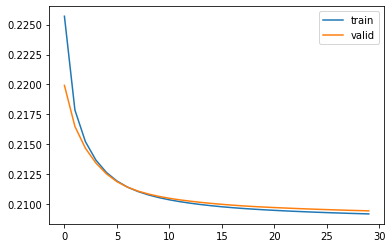

In [19]:

import matplotlib.pyplot as plt
results_train_data_all = []
results_valid_data_all = []
results_train_data_all = np.zeros(epoch+1)
results_valid_data_all = np.zeros(epoch+1)
# 目的関数の出力 (loss)
for i in range(split_num):   
    results_train_data_all += results_train_data[i]['loss']
    results_valid_data_all += results_valid_data[i]['loss']
    #plt.plot(results_train_data[i]['loss'], label='train')  # label で凡例の設定
    #plt.plot(results_valid_data[i]['loss'], label='valid')  # label で凡例の設定
    #plt.legend()  # 凡例の表示
    #plt.figure()

plt.plot(results_train_data_all / 10, label='train')  # label で凡例の設定
plt.plot(results_valid_data_all / 10, label='valid')  # label で凡例の設定
plt.legend()  # 凡例の表示


In [9]:
print(type(results_train_data[0]['loss'][0]))

<class 'numpy.float32'>
